## **State updates by nodes**

* In the previous notebook the state is being overwritten by the nodes which means we are losing all the updates
* If we want to preserve the previous data or make transformations on top of that data, we can use Anootations and reducer functions
* The following example shows three ways updates can be done. Either through messages, math operations or string operations
* As is shown in the example, state is not preserved between two seperate runs. Each run is isolated. The state updates are only applicable until the execution of the graph. After the execution, the state gets reset

In [1]:
from langgraph.graph import StateGraph, add_messages, START, END
from typing_extensions import TypedDict, Annotated
from operator import add

In [2]:
class State(TypedDict):
    var1: Annotated[list[str], add_messages]
    var2: Annotated[int, add]
    var3: Annotated[str, add]

In [3]:
builder1 = StateGraph(State)

def node1(state: State):
    return {"var1": ["b"], "var2": 2, "var3": "b"}

def node2(state: State):
    return {"var1": ["c"], "var2": 3, "var3": "c"}

builder1.add_node(node1, "node1")
builder1.add_node(node2, "node2")

builder1.add_edge(START, "node1")
builder1.add_edge("node1", "node2")
builder1.add_edge("node2", END)

graph1 =  builder1.compile()
graph1.debug = True

In [4]:
print(graph1.get_graph().print_ascii())

+-----------+  
| __start__ |  
+-----------+  
      *        
      *        
      *        
  +-------+    
  | node1 |    
  +-------+    
      *        
      *        
      *        
  +-------+    
  | node2 |    
  +-------+    
      *        
      *        
      *        
 +---------+   
 | __end__ |   
 +---------+   
None


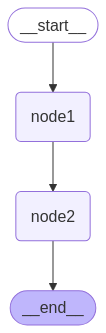

In [5]:
graph1

In [6]:
graph1.invoke({"var1": ["a"], "var2": 1, "var3": "a"})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': ''}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['a'], 'var2': 1, 'var3': 'a'}
[0:writes] Finished step 0 with writes to 3 channels:
- var1 -> ['a']
- var2 -> 1
- var3 -> 'a'
[0:checkpoint] State at the end of step 0:
{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89')],
 'var2': 1,
 'var3': 'a'}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89')],
 'var2': 1,
 'var3': 'a'}
[1:writes] Finished step 1 with writes to 3 channels:
- var1 -> ['b']
- var2 -> 2
- var3 -> 'b'
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89'),
          HumanMessage(content='b', additional_kwargs={}, response_metada

{'var1': [HumanMessage(content='a', additional_kwargs={}, response_metadata={}, id='d494794b-815f-4799-9bff-d5e5bf8bfc89'),
  HumanMessage(content='b', additional_kwargs={}, response_metadata={}, id='55402d94-05c0-4074-b32f-f44a07ecf143'),
  HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='8c58a48c-1169-459f-9a05-d2075630790c')],
 'var2': 6,
 'var3': 'abc'}

In [7]:
graph1.invoke({"var1": ["c"], "var2": 5, "var3": "c"})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': ''}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'var1': ['c'], 'var2': 5, 'var3': 'c'}
[0:writes] Finished step 0 with writes to 3 channels:
- var1 -> ['c']
- var2 -> 5
- var3 -> 'c'
[0:checkpoint] State at the end of step 0:
{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415')],
 'var2': 5,
 'var3': 'c'}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415')],
 'var2': 5,
 'var3': 'c'}
[1:writes] Finished step 1 with writes to 3 channels:
- var1 -> ['b']
- var2 -> 2
- var3 -> 'b'
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415'),
          HumanMessage(content='b', additional_kwargs={}, response_metada

{'var1': [HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='a90d8633-a41a-4aa7-a437-ee509a5b6415'),
  HumanMessage(content='b', additional_kwargs={}, response_metadata={}, id='3ae163df-c8a3-4952-8923-71154fa6dae1'),
  HumanMessage(content='c', additional_kwargs={}, response_metadata={}, id='b5035ed7-7742-4e5b-a53b-b104aa516a60')],
 'var2': 10,
 'var3': 'cbc'}

## **Multiple Annotated states**

* Overall state uses add_messages as reducer and input and output states use add operator as reducer
* As provided, the add_messages reducer adds Human message objects to the list
* add operator simply extend the list with the new data
* We can even update multiple states as needed in a single node

In [8]:
from operator import add

class State1(TypedDict):
    vara: Annotated[list[str], add]

class State2(TypedDict):
    varb: Annotated[list[str], add]

In [9]:
builder2 = StateGraph(State, input = State1, output = State2)

def node1(state: State1) -> State2:
    data = "".join(state["vara"]) + "1"
    return {"varb": [data], "var1" : [data]}

def node2(state: State2) -> State2:
    data = "".join(state["varb"]) + "2"
    return {"varb": [data], "var1" : [data]}

def node3(state: State2) -> State1:
    data = "".join(state["varb"]) + "3"
    return {"vara": [data], "var1" : [data]}

builder2.add_node(node1, "node1")
builder2.add_node(node2, "node2")
builder2.add_node(node3, "node3")

builder2.add_edge(START, "node1")
builder2.add_edge("node1", "node2")
builder2.add_edge("node2", "node3")
builder2.add_edge("node3", END)

graph2 = builder2.compile()
graph2.debug = True

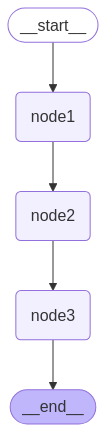

In [10]:
graph2

In [13]:
graph2.invoke({"vara": ["1"]})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'vara': ['1']}
[0:writes] Finished step 0 with writes to 1 channel:
- vara -> ['1']
[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': ['1'], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': ['1']}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['11']
- var1 -> ['11']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='11', additional_kwargs={}, response_metadata={}, id='0381af6a-edd3-4ca5-a5a7-02ac416a0471')],
 'var2': 0,
 'var3': '',
 'vara': ['1'],
 'varb': ['11']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['11']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['112']
- var1 -> ['112']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='11', additional_kwargs={}, response_meta

{'varb': ['11', '112']}

In [12]:
graph2.invoke({"vara": ["0"]})

[-1:checkpoint] State at the end of step -1:
{'var1': [], 'var2': 0, 'var3': '', 'vara': [], 'varb': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'vara': ['0']}
[0:writes] Finished step 0 with writes to 1 channel:
- vara -> ['0']
[0:checkpoint] State at the end of step 0:
{'var1': [], 'var2': 0, 'var3': '', 'vara': ['0'], 'varb': []}
[1:tasks] Starting 1 task for step 1:
- node1 -> {'vara': ['0']}
[1:writes] Finished step 1 with writes to 2 channels:
- varb -> ['01']
- var1 -> ['01']
[1:checkpoint] State at the end of step 1:
{'var1': [HumanMessage(content='01', additional_kwargs={}, response_metadata={}, id='1d4316ba-fdd7-4612-a270-7671c43a1a5e')],
 'var2': 0,
 'var3': '',
 'vara': ['0'],
 'varb': ['01']}
[2:tasks] Starting 1 task for step 2:
- node2 -> {'varb': ['01']}
[2:writes] Finished step 2 with writes to 2 channels:
- varb -> ['012']
- var1 -> ['012']
[2:checkpoint] State at the end of step 2:
{'var1': [HumanMessage(content='01', additional_kwargs={}, response_meta

{'varb': ['01', '012']}